## TEST HYPATIA

In [5]:
# Schechter redshift dependency on HST data




import copy
import os, sys
#from nflows import transforms, distributions, flows
import torch
from scipy.special import logsumexp
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.interpolate import interp1d

from torch import nn
from torch import optim
import torch.distributions as D
import emcee
import corner
import time
from multiprocessing import cpu_count, Pool

import os
import h5py 
import numpy as np
# import fitsio
# from tqdm.auto import trange
import astropy.table as aTable
from astropy.cosmology import Planck13
from astropy.cosmology import FlatLambdaCDM




# ### Methods

# #### Mass completeness limit $M(z)$




def mass_completeness_limit_hst(z):
    
    x_values = [0.5, 0.65, 1.0, 1.5, 2.1, 3.0]
    y_values = [8.72, 8.72, 9.07, 9.63, 9.79, 10.15]
    
    f = interp1d(x_values, y_values)
    return f(z)


def mass_completeness_limit_cosmos(z):
    x_values = [0.175, 0.5, 0.8, 1.125, 1.525, 2.0, 2.5, 3.125, 3.75, 4.4]
    y_values = [8.1, 8.7, 9.1, 9.3, 9.7, 9.9, 10.0, 10.1, 10.1, 10.1]

    f = interp1d(x_values, y_values)
    return f(z)


def mass_completeness_limit_bgs(z):
    f, b, c = [-1.34199453, 13.90578909,  8.53522654]
    return 4*np.pi*f*z**2 + b*z + c



def gathering_data_hst(data, zmin, zmax):

    hst = data
    mask_zlim = (hst['z_peak'].data > zmin) & (hst['z_peak'].data < zmax)
    
    z_tot = hst['z_peak'].data[mask_zlim]
    x_tot = hst['lmass'].data[mask_zlim]
    
    
    mass_comp_lim = mass_completeness_limit_hst(z_tot)
    # mask_mlim = []
    # for i in range(len(x_median_tot)):
    #     mask_mlim.append(x_median_tot[i] > mass_comp_lim[i])
    mask_mlim = (x_tot > mass_completeness_limit_hst(z_tot))  & (x_tot < 12.)
        
    
    mask = (mask_mlim)
    
    z = z_tot[mask].astype(np.float32)
    x = x_tot[mask].astype(np.float32)
    
    return z, x



def gathering_data_cosmos(data, zmin, zmax):
    cosmos = data
    
    mask_ultra = (cosmos['FLAG_HJMCC']==0) & (cosmos['FLAG_COSMOS']==1) & (cosmos['FLAG_PETER']==0)
    
    z_tot = cosmos['ZPDF'][mask_ultra].data
    x_tot = cosmos['MASS_MED'][mask_ultra].data
    
    mask_zlim = (z_tot > zmin) & (z_tot < zmax) & (x_tot > 0)

    z2 = z_tot[mask_zlim]
    x2 = x_tot[mask_zlim]
    
    mask_mlim = (x2 > mass_completeness_limit_cosmos(z2))

    return z2[mask_mlim].astype(np.float32), x2[mask_mlim].astype(np.float32)



def gathering_data_bgs(data, zmin, zmax):

    bgs = data
    mask_zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)
    
    z_tot = bgs['Z_HP'].data[mask_zlim]
    x_tot = bgs['provabgs_logMstar'].data[mask_zlim]
    x_median_tot = np.median(x_tot, axis=1)
    w_zfail_tot = bgs['provabgs_w_zfail'].data[mask_zlim]
    w_fib_tot = bgs['provabgs_w_fibassign'].data[mask_zlim]
    vmax_tot = bgs['Vmax'].data[mask_zlim]
    
    
    mass_comp_lim = mass_completeness_limit_bgs(z_tot)
    # mask_mlim = []
    # for i in range(len(x_median_tot)):
    #     mask_mlim.append(x_median_tot[i] > mass_comp_lim[i])
    mask_mlim = x_median_tot > mass_completeness_limit_bgs(z_tot)
        
    
    mask = (w_zfail_tot > 0) & (mask_mlim)
    
    z = z_tot[mask].astype(np.float32)
    x = x_tot[mask].astype(np.float32)
    x_median = x_median_tot[mask].astype(np.float32)
    w_zfail = w_zfail_tot[mask].astype(np.float32)
    w_fib = w_fib_tot[mask].astype(np.float32)
    vmax = vmax_tot[mask].astype(np.float32)
    
    
    f_area = (173.641/(4.*np.pi*(180/np.pi)**2))
    v_zmin = Planck13.comoving_volume(0.01).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(0.09).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_sub = v_zmax - v_zmin
    
    
    # w_spec * 1/Vmax
    w = (w_zfail*w_fib) * v_sub / (vmax.clip(v_zmin, v_zmax) - v_zmin)
    n = np.sum(w)/v_sub
    
    # Spectroscopic weights
    w_spec = (w_zfail*w_fib)

    return z, x, x_median, w_spec, vmax



# #### Schechter function $\phi(M_{*}, z)$



# For Emcee fit
# def smf_single_schechter_sty_noz(x, logM, alpha1):
#     term0 = np.exp(-10 ** (x-logM))
#     term1 = 10 ** ((alpha1+1)*(x - logM))
#     return term0 * term1


# def smf_single_schechter_sty(x, z, a0, a1, a2, a3):
#     logM = a0 + a1 * z
#     alpha1 = a2 + a3 * z
    
#     term0 = np.exp(-10 ** (x-logM[:,None]))
#     term1 = 10 ** ((alpha1+1)[:,None]*(x - logM[:,None]))
#     return term0 * term1


def smf_single_schechter_sty(x, z, a0, a1, a2, a3):
    logM = a0 + a1 * z
    alpha1 = a2 + a3 * z
    
    term0 = np.exp(-10 ** (x-logM))
    term1 = 10 ** ((alpha1+1)*(x - logM))
    return term0 * term1


def smf_double_schechter_sty(x, z,  a0, a1, a2, alpha1, alpha2, a7, a8, a9):
    logM = a0*z**2 + a1*z + a2
#     alpha1 = -.28
#     alpha2 = -1.48
    log_phi2_phi1 = a7*z**2 + a8*z + a9
    
    term0 = np.exp(-10 ** (x-logM))
    term1 = 10 ** ((alpha2+1)*(x - logM))
    term2 = 10 ** ((alpha1+1)*(x - logM) + log_phi2_phi1)
    return term0 * (term1 + term2)



def smf_single_schechter_integral(x, z, a0, a1, a2, a3):
    logM = a0 + a1*z
    alpha1 = a2 + a3*z
    term0 = np.exp(-10 ** (x-logM))
    term1 = 10 ** ((alpha1+1)*(x - logM))
    return term0 * term1


# #### Log Likelihood - prior - posterior




# def log_likelihood(a0, a1, a2, a3, z, x):
#     q = smf_single_schechter_sty(x, z, a0, a1, a2, a3)

#     mlim = mass_completeness_limit(z)
#     I = [integrate.quad(smf_single_schechter_integral, mlim[i], 15., args=(z[i], a0, a1, a2, a3))[0] for i in range(z.shape[0])]

#     a = np.log10(q) - np.log10(I)
    
#     return a


def log_likelihood(a0, a1, a2, alpha1, alpha2, a7, a8, a9, x, z):
    q = smf_double_schechter_sty(x, z, a0, a1, a2, alpha1, alpha2, a7, a8, a9)

    mlim = mass_completeness_limit(z)
    I = [integrate.quad(smf_double_schechter_sty, mlim[i], 12.,
                        args=(z[i], a0, a1, a2, alpha1, alpha2, a7, a8, a9))[0] for i in range(z.shape[0])]

    a = np.log10(q) - np.log10(I)
    
    return a




def log_prior(theta):
    a0, a1, a2, alpha1, alpha2, a7, a8, a9 = theta
    if -4. < a0 < 4. and \
        -4. < a1 < 4. and \
       8. < a2 < 13.  and \
        -1 < alpha1 < 2 and \
        -2 < alpha2 < -0.5 and \
        -3 < a7 < 3 and \
        -3 < a8 < 3 and \
        -3 < a9 < 3:
        return 0
    return -np.inf

#        -4. < a3 < 4. and \
#         -4 < a4 < 4 and \
#         -4 < a5 < 4 and \
#         -4 < a6 < 4 and \

def posterior(theta, x, z):
    a0, a1, a2, alpha1, alpha2, a7, a8, a9 = theta
    l = log_likelihood(a0, a1, a2, alpha1, alpha2, a7, a8, a9, x, z)
    return log_prior(theta) + np.sum(l)



# input
# zmin = float(sys.argv[1])
# zmax = float(sys.argv[2])
# nwalkers = int(sys.argv[3])
# nstep = int(sys.argv[4])
# label = str(sys.argv[5])


data_dir = '../data'
data_file_bgs = 'BGS_ANY_full.provabgs.lite.hdf5'
data_file_cosmos = 'COSMOS2015_Laigle+_v1.1.lite.hdf5'
data_file_hst = '3dhst_master.phot.v4.1.cat.lite.hdf5'

path_to_data_bgs = os.path.join(data_dir,data_file_bgs)
path_to_data_cosmos = os.path.join(data_dir,data_file_cosmos)
path_to_data_hst = os.path.join(data_dir,data_file_hst)

bgs = aTable.Table.read(path_to_data_bgs)
cosmos = aTable.Table.read(path_to_data_cosmos)
hst = aTable.Table.read(path_to_data_hst)


is_bgs_bright = bgs['is_bgs_bright']
is_bgs_faint = bgs['is_bgs_faint']

bgs = bgs[bgs['is_bgs_bright']]

zmin_bgs, zmax_bgs = 0.01, 0.4
zmin_cosmos, zmax_cosmos = 0.2, 0.8
zmin_hst, zmax_hst = 0.5, 3.


z_bgs, x_bgs, x_median_bgs, w_spec, v_max = gathering_data_bgs(bgs, zmin_bgs, zmax_bgs)
z_cosmos, x_cosmos = gathering_data_cosmos(cosmos, zmin_cosmos, zmax_cosmos)
z_hst, x_hst = gathering_data_hst(hst, zmin_hst, zmax_hst)


z = np.concatenate((z_bgs, z_cosmos, z_hst))
x = np.concatenate((x_median_bgs, x_cosmos, x_hst))

(6.0, 14.0)

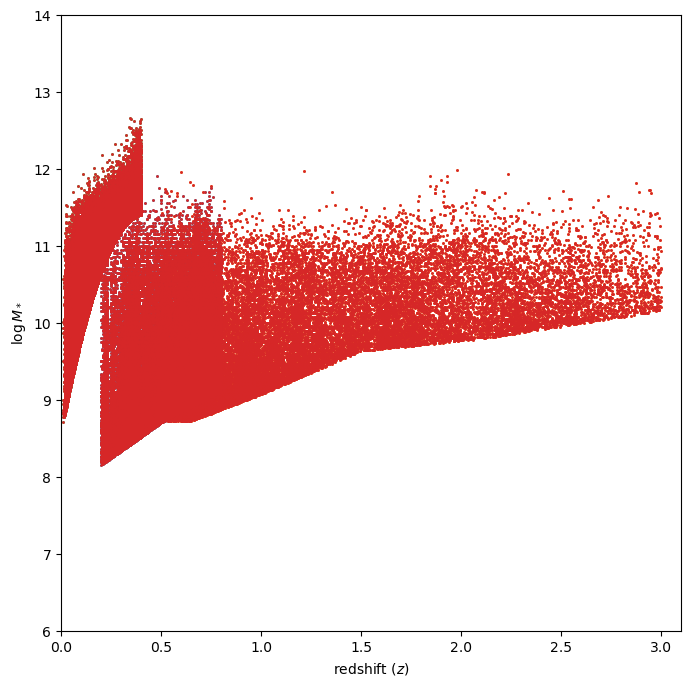

In [6]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,8))
plt.scatter(z_hst, x_hst, s=1, c='C1', label='HST')
plt.scatter(z_cosmos, x_cosmos, s=1, c='C0', label='COSMOS')
plt.scatter(z_bgs, x_median_bgs, s=1, c='C2', label='BGS')
plt.scatter(z, x, s=1, c='C3', label='TOT')

plt.xlabel(r"redshift ($z$)")
plt.xlim(0., 3.1)
plt.ylabel(r"$\log M_*$")
plt.ylim(6., 14.)

In [ ]:
from astropy.cosmology import Planck13, Planck15, Planck18
from scipy.interpolate import interp1d
from scipy import integrate

In [ ]:
import sys
import numpy as np
from matplotlib import pyplot as plt


sys.path.append('../')

from BGS import BGS
from HST import HST
from COSMOS import COSMOS

from FileEmcee import FileEmcee
from EmceeRun import EmceeRun

from Plotter import Plotter
from PlotterHst import PlotterHst
from PlotterCOSMOS import PlotterCOSMOS

from VMaxDensity import VmaxDensity
from VMaxDensityHst import VmaxDensityHst

from ZSchechterModel import ZSchechterModel
from NoZSchechterModel import NoZSchechterModel

from Fileh5 import Fileh5

In [ ]:
cosmos = COSMOS('COSMOS2015_Laigle+_v1.1.lite.hdf5')
hst = HST('3dhst_master.phot.v4.1.cat.lite.hdf5')
bgs = BGS('BGS_ANY_full.provabgs.lite.hdf5')
emcee_file = Fileh5(folder='emcee_runs', info_file='ZSchechter_50w_100step_0.175_2.0_cosmos.h5')
emcee_run = EmceeRun(emcee_file)

In [ ]:
plotter_cosmos = PlotterCOSMOS(cosmos, emcee_run)

In [ ]:
plt.figure(figsize=(8,8))
plotter_cosmos.plot_selected_data(0.2, 4.4)

In [ ]:
z_cosmos, x_cosmos = cosmos.select_galaxies(0.2, 0.8)
z_hst, x_hst = hst.select_galaxies(0.5, 3.0)
z_bgs, x_bgs, x_median_bgs, w_spec, vmax = bgs.select_galaxies(0.01, 0.3)

In [ ]:
z_lin = np.linspace(0.2, 4.4, 100)

plt.figure(figsize=(8,8))
# plt.scatter(z_cosmos, x_cosmos, s=1, c='lightgrey', label='COSMOS')
plt.scatter(z_hst, x_hst, s=1, c='C1', label='HST')
plt.scatter(z_cosmos, x_cosmos, s=1, c='C0', label='COSMOS')
plt.scatter(z_bgs, x_median_bgs, s=1, c='C2', label='BGS')

# plt.scatter(z_hst, x_hst, s=1, c='lightgrey', label='COSMOS')

plt.plot(z_lin, cosmos.mass_completeness_limit(z_lin), color='orange', linewidth=0.9)
plt.plot(z_lin, cosmos.mass_completeness_limit(z_lin), color='orange', linewidth=0.9)

plt.legend(loc='lower right', fontsize=10, markerscale=10, handletextpad=0.1)
plt.xlabel(r"redshift ($z$)")
plt.xlim(0., 3.1)
plt.ylabel(r"$\log M_*$")
plt.ylim(6., 14.)

# 3D-HST Leja et al.

In [ ]:
# 3D-HST
def zmax_lim(mstar):
    y_values = [8.72, 8.72, 9.07, 9.63, 9.79, 10.15]
    x_values = [0.5, 0.65, 1.0, 1.5, 2.1, 3.0]

    f = interp1d(y_values, x_values)
    if mstar > y_values[-1]:
        return x_values[-1]
    else:
        return f(mstar)

In [ ]:
def mass_completeness_limit(z):
    
    x_values = [0.65, 1.0, 1.5, 2.1, 3.0]
    y_values = [8.72, 9.07, 9.63, 9.79, 10.15]
    
    f = interp1d(x_values, y_values)
    return f(z)



def gathering_data(data, zmin, zmax):

    hst = data
    mask_zlim = (hst['z_peak'].data > zmin) & (hst['z_peak'].data < zmax)
    
    z_tot = hst['z_peak'].data[mask_zlim]
    x_tot = hst['lmass'].data[mask_zlim]
    
    
    mass_comp_lim = mass_completeness_limit(z_tot)
    # mask_mlim = []
    # for i in range(len(x_median_tot)):
    #     mask_mlim.append(x_median_tot[i] > mass_comp_lim[i])
    mask_mlim = x_tot > mass_completeness_limit(z_tot)
        
    
    mask = (mask_mlim)
    
    z = z_tot[mask].astype(np.float32)
    x = x_tot[mask].astype(np.float32)
    
    return z, x

In [ ]:
hst = Table.read('../data/3dhst_master.phot.v4.1.cat.FITS')

In [ ]:
hst[:5]

In [ ]:
z, x = gathering_data(hst, 0.65, 3.0)

In [ ]:
z_lin = np.linspace(0.65, 3.0, 100)
plt.figure(figsize=(8,8))
plt.plot(z, x, 'o', markersize=1)
plt.plot(z_lin, mass_completeness_limit(z_lin))
plt.xlabel(r"redshift ($z$)")
plt.ylabel(r"$\log M_*$")
# plt.xlim(0.5, 3.5)
plt.ylim(8., 15)


In [ ]:
write_table_hdf5(hst['lmass', 'z_peak'], '3dhst_master.phot.v4.1.cat.lite.hdf5', overwrite=True)

In [ ]:
x.shape

In [ ]:
lmass = hst['lmass']
# z_spec = hst['z_spec']
z_peak = hst['z_peak']

# mask_spec = (z_spec >= 0.)
mask_peak = (z_peak >= 0.) & (lmass > 0.)

In [ ]:
mass_complete = np.array(list(zip([0.65, 1.0, 1.5, 2.1, 3.0], [8.72, 9.07, 9.63, 9.79, 10.15])))

In [ ]:
mass_complete[:,0]


In [ ]:
hst['lmass','z_peak'].to_pandas().to_hdf('3dhst_master.phot.v4.1.cat.lite.hdf5', key='hst_lite', mode='w')

In [ ]:
# cosmos = h5py.File('../data/COSMOS2015_Laigle+_v1.1.lite.hdf5')

In [ ]:
cosmos = aTable.Table.read('../data/COSMOS2015_Laigle+_v1.1.lite.hdf5')

In [ ]:
# z, x = gathering_data(cosmos, 0.175, 4.4)

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(z, x, 'o', markersize=0.3)
# plt.plot(np.linspace(0.175, 4.4, 100), mass_completeness_limit(np.linspace(0.175, 4.4, 100)))
# plt.plot(mass_complete_cosmos[:,0], mass_complete_cosmos[:,1])
# plt.plot(np.linspace(x_values[0],x_values[-1],100), mass_completeness_cosmos(np.linspace(x_values[0],x_values[-1],100)))

In [ ]:
z.shape

In [ ]:
z_cosmos = cosmos['ZPDF']
m_cosmos = cosmos['MASS_MED']
mask = (z_cosmos >= .175) & (z_cosmos <= 4.4) & (m_cosmos > 8.1)
z = z_cosmos[mask]
mask_lim = m_cosmos > mass_completeness_cosmos(z)
mstar = m_cosmos[mask_lim]
z = z_cosmos[mask_lim]

In [ ]:
mass_complete_cosmos = np.array(list(zip([0.175, 0.5, 0.8, 1.125, 1.525, 2.0, 2.5, 3.125, 3.75, 4.4], 
                                         [8.1, 8.7, 9.1, 9.3, 9.7, 9.9, 10.0, 10.1, 10.1, 10.1])))

In [ ]:
x_values = [0.175, 0.5, 0.8, 1.125, 1.525, 2.0, 2.5, 3.125, 3.75, 4.4]

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(z, x, 'o', markersize=1)
plt.plot(mass_complete_cosmos[:,0], mass_complete_cosmos[:,1])
plt.plot(np.linspace(x_values[0],x_values[-1],100), mass_completeness_cosmos(np.linspace(x_values[0],x_values[-1],100)))

plt.xlabel(r"redshift ($z$)")
plt.ylabel(r"$\log M_*$")
# plt.xlim(0.5, 3.5)
# plt.ylim(8., 15)

In [ ]:

x_values = [0.175, 0.5, 0.8, 1.125, 1.525, 2.0, 2.5, 3.125, 3.75, 4.4]
y_values = [8.1, 8.7, 9.1, 9.3, 9.7, 9.9, 10.0, 10.1, 10.1, 10.1]

f = interp1d(x_values, y_values)

In [ ]:
f(1.3)

In [ ]:
def mass_completeness_cosmos(x):
    
    x_values = [0.175, 0.5, 0.8, 1.125, 1.525, 2.0, 2.5, 3.125, 3.75, 4.4]
    y_values = [8.1, 8.7, 9.1, 9.3, 9.7, 9.9, 10.0, 10.1, 10.1,10.1]

    f = interp1d(x_values, y_values)
    return f(x)

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(z_cosmos[mask], m_cosmos[mask], 'o', markersize=1)
plt.plot(mass_complete_cosmos[:,0], mass_complete_cosmos[:,1])
plt.plot(np.linspace(x_values[0], x_values[-1], 100), mass_completeness_cosmos(np.linspace(x_values[0], x_values[-1], 100)))
plt.xlabel(r"redshift ($z$)")
plt.ylabel(r"$\log M_*$")
# plt.xlim(0.5, 3.5)
# plt.ylim(8., 15)
# plt.plot(np.linspace(1, 10, 100), mass_completeness_cosmos(np.linspace(1, 10, 100)))

# COSMOS2015 Laigle et al. 2016

In [ ]:
from astropy.table import Table

In [ ]:
cosmos2015 = Table.read('../data/COSMOS2015_Laigle+_v1.1.fits')

In [ ]:
from astropy.io.misc.hdf5 import write_table_hdf5

In [ ]:
write_table_hdf5(cosmos2015['ZPDF', 'MASS_MED', 'FLAG_HJMCC', 'FLAG_COSMOS', 'FLAG_PETER'], 'COSMOS2015_Laigle+_v1.1.lite.hdf5')

In [ ]:
cosmos2015[:5]

In [ ]:
mask = (cosmos2015['ZPDF'] >= 0.) & (cosmos2015['MASS_MED'] > 0.) & (cosmos2015['FLAG_HJMCC']==0) & (cosmos2015['FLAG_COSMOS']==1) & (cosmos2015['FLAG_PETER']==0)

In [ ]:
cosmos2015['ZPDF'][mask].shape

In [ ]:
mask_flag = (cosmos2015['FLAG_DEEP'] == 1)

In [ ]:
c = cosmos2015['ZPDF'][mask_flag]

In [ ]:
c[:5]

In [ ]:
z_cosmos = cosmos2015['ZPDF']
m_cosmos = cosmos2015['MASS_MED']
mask = (z_cosmos >= 0.) & (m_cosmos > 0.)

In [ ]:
mass_complete_cosmos = np.array(list(zip([0.175, 0.5, 0.8, 1.125, 1.525, 2.0, 2.5, 3.125, 3.75, 4.4], 
                                         [8.1, 8.7, 9.1, 9.3, 9.7, 9.9, 10.0, 10.1, 10.1])))

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(z_cosmos[mask], m_cosmos[mask], 'o', markersize=1)
plt.plot(mass_complete_cosmos[:,0], mass_complete_cosmos[:,1])
plt.xlabel(r"redshift ($z$)")
plt.ylabel(r"$\log M_*$")
# plt.xlim(0.5, 3.5)
# plt.ylim(8., 15)


In [ ]:
cosmos2015['ZPDF', 'MASS_MED'].to_pandas().to_hdf('../data/COSMOS2015_Laigle+_v1.1.lite.hdf5', key='cosmos_lite', mode='w')